# Advanced Building Blocks

## Loading Libraries

In [1]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib
import matplotlib_inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches

# Dataset's Iteration Performance
from tqdm import tqdm

# Time
import time

# OS
import re
import sys
import json
import string
import unicodedata
from glob import glob
from PIL import Image
from io import BytesIO
from imageio import imread
from zipfile import ZipFile
import requests, zipfile, io
from collections import Counter
from urllib.request import urlopen

# Warnings 
import warnings
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

# SciPy
import scipy
from scipy.signal import convolve

# PyTorch
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import *
from torchvision.ops import nms
import torch.nn.functional as F
from torchvision import transforms
# from torchtext.datasets import AG_NEWS
# from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# IDLMAM Libraries
from idlmam import moveTo, run_epoch, set_seed, View, pad_and_pack
from idlmam import train_simple_network, set_seed, Flatten, weight_reset, train_network
from idlmam import LanguageNameDataset, pad_and_pack, EmbeddingPackable, LastTimeStep, LambdaLayer
from idlmam import AttentionAvg, GeneralScore, DotScore, AdditiveAttentionScore, ApplyAttention, getMaskByFill

# Scikit-Learn
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# IPython Display
from IPython.display import Latex
from IPython.display import display_pdf
from IPython.display import set_matplotlib_formats

/shared-libs/python3.10/py/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Visualization Set-Up

In [2]:
%matplotlib inline

matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')

### Setting Seeds & Device

In [3]:
torch.backends.cudnn.deterministic=True

set_seed(42)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")  

## Problems with Pooling

Image downloaded and saved as downloaded_image.jpg


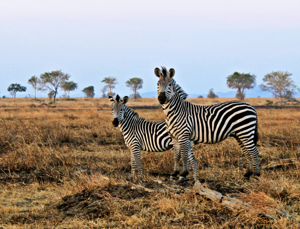

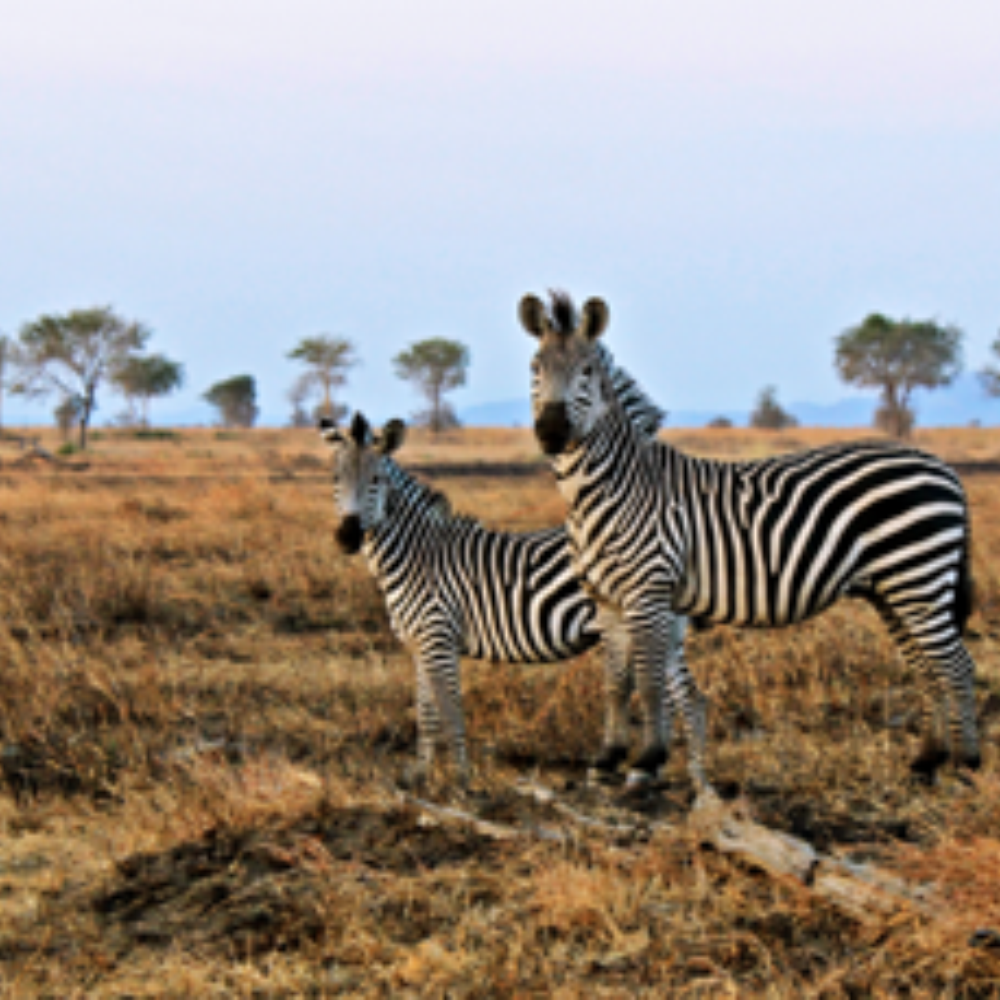

In [4]:
# URL of the image
url = "https://upload.wikimedia.org/wikipedia/commons/9/9c/Zebra_in_Mikumi.JPG"

# Fetching the image with headers
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

response = requests.get(url, headers=headers)

# Verify the request was successful
if response.status_code == 200:
    try:
        img = Image.open(BytesIO(response.content))
        img.save("downloaded_image.jpg")  # Save the image locally
        print("Image downloaded and saved as downloaded_image.jpg")
        
        # Display the image in a smaller form
        img.thumbnail((300, 300))
        img.show()
        
        # Image transformations
        to_tensor = transforms.ToTensor()
        resize = torchvision.transforms.Resize(1000)
        crop = torchvision.transforms.CenterCrop((1000, 1000))
        
        # Transform the image
        img_tensor_big = to_tensor(crop(resize(img)))
        
        # Convert tensor back to image
        to_img = transforms.ToPILImage()
        img_transformed = to_img(img_tensor_big)
        img_transformed.show()  # Display the transformed image
        
    except (IOError, SyntaxError) as e:
        print(f"Error opening image: {e}")
else:
    print(f"Error fetching image, status code: {response.status_code}")

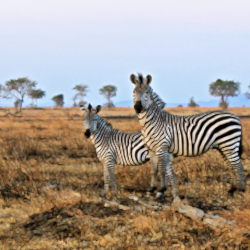

In [5]:
# Image Shrink 
shrink_factor = 4 

# Applying Pooling
img_tensor_small = F.max_pool2d(img_tensor_big, (shrink_factor,shrink_factor)) 

to_img(img_tensor_small)

### Aliasing Compromises Translation Invariance

In [6]:
# Batch Size
B = 128

# Epochs
epochs = 30

train_transform = transforms.Compose( 
    [
        transforms.RandomCrop((24,24)),
        transforms.ToTensor(),
    ])
test_transform = transforms.Compose( 
    [
        transforms.CenterCrop((24,24)),
        transforms.ToTensor(),
    ])

# Training Set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=B, shuffle=True, num_workers=2)

# Testing Set
testset_nocrop = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Test Loader
test_loader = torch.utils.data.DataLoader(testset, batch_size=B, shuffle=False, num_workers=2)
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') #Mappn

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


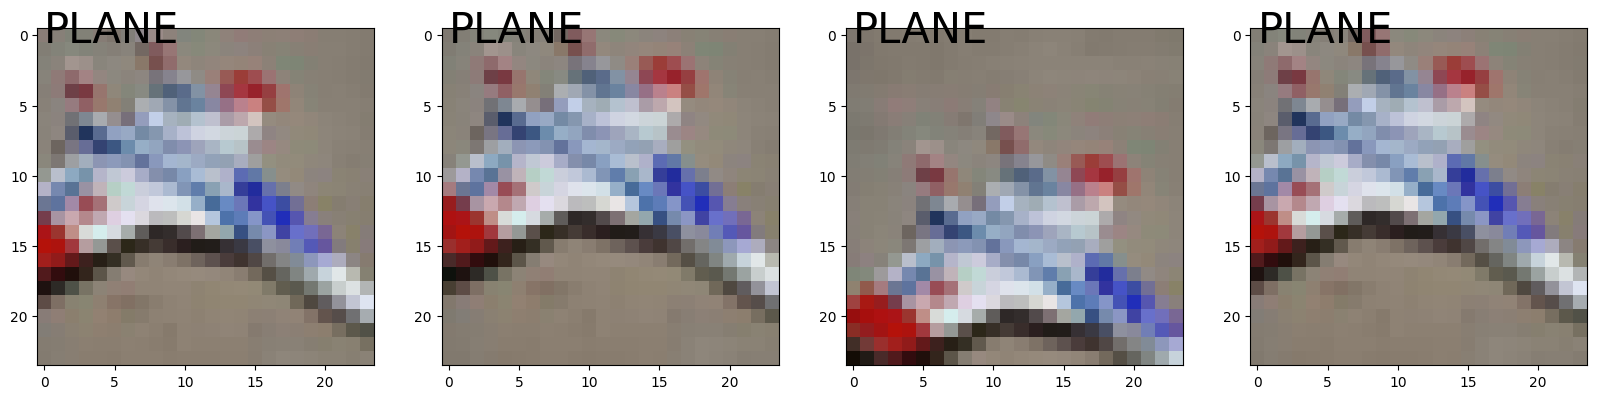

In [7]:
f, axarr = plt.subplots(1,4, figsize=(20,10)) 

for i in range(4): 
    x, y = trainset[30] 
    axarr[i].imshow(x.numpy().transpose(1,2,0)) 
    axarr[i].text(0.0, 0.5, cifar10_classes[y].upper(), dict(size=30, color='black')) 

In [8]:
# Input Channels
C = 3 

# Hidden Layers
h = 16 

# Filter Size
filter_size = 3

# Pooling
pooling_rounds = 2

# Helper Function
def cnnLayer(in_size, out_size, filter_size): 
    return nn.Sequential(
        nn.Conv2d(in_size, out_size, filter_size, padding=filter_size//2),
        nn.BatchNorm2d(out_size),
        nn.ReLU())

normal_CNN = nn.Sequential( 
    cnnLayer(C, h, filter_size), 
    cnnLayer(h, h, filter_size),
    nn.MaxPool2d(2),
    cnnLayer(h, h, filter_size),
    cnnLayer(h, h, filter_size),
    nn.MaxPool2d(2),
    cnnLayer(h, h, filter_size),
    cnnLayer(h, h, filter_size),
    nn.Flatten(),
    nn.Linear(h*(24//(2**pooling_rounds))**2, len(cifar10_classes)) 
)

# Loss Function
loss = nn.CrossEntropyLoss()

# Optimizer & Scheduler
optimizer = torch.optim.AdamW(normal_CNN.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

In [9]:
normal_results = train_network(normal_CNN, 
loss, 
train_loader, 
epochs=epochs, 
device=device,  
test_loader=test_loader, 
optimizer=optimizer, 
lr_schedule=scheduler, 
score_funcs={'Accuracy': accuracy_score})

Training: 100%|█████████▉| 390/391 [00:10<00:00, 39.25it/s]
                                                           
Training:  99%|█████████▉| 389/391 [00:10<00:00, 36.74it/s]
                                                           
Training:  99%|█████████▉| 387/391 [00:10<00:00, 35.57it/s]
                                                           
Training:  99%|█████████▉| 387/391 [00:09<00:00, 39.56it/s]
                                                           
Training:  99%|█████████▉| 388/391 [00:10<00:00, 38.36it/s]
                                                           
Training:  99%|█████████▉| 388/391 [00:09<00:00, 38.50it/s]
                                                           
Training:  99%|█████████▉| 387/391 [00:10<00:00, 39.64it/s]
                                                           
Training:  99%|█████████▉| 389/391 [00:10<00:00, 38.19it/s]
                                                           
Training: 100%|█████████▉| 390/391 [00:0

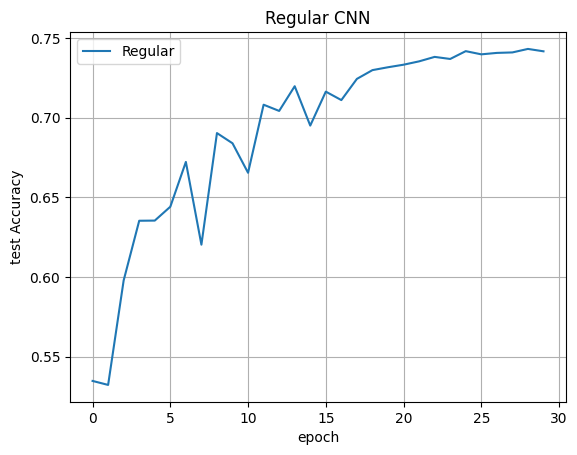

In [10]:
sns.lineplot(x='epoch', y='test Accuracy', data=normal_results, label='Regular')

plt.title('Regular CNN')
plt.grid(True)
plt.show()

In [11]:
test_img_id = 213 
x, y = testset_nocrop[test_img_id] 
offset_predictions = [] 
normal_CNN = normal_CNN.eval()

for i in range(8): 
    for j in range(8): 
        x_crop = x[:,i:i+24, j:j+24].to(device) 
        with torch.no_grad(): 
            prob_y = F.softmax(normal_CNN(x_crop.unsqueeze(0)), dim=-1).cpu().numpy()[0,y] 
            offset_predictions.append((x_crop, prob_y)) 

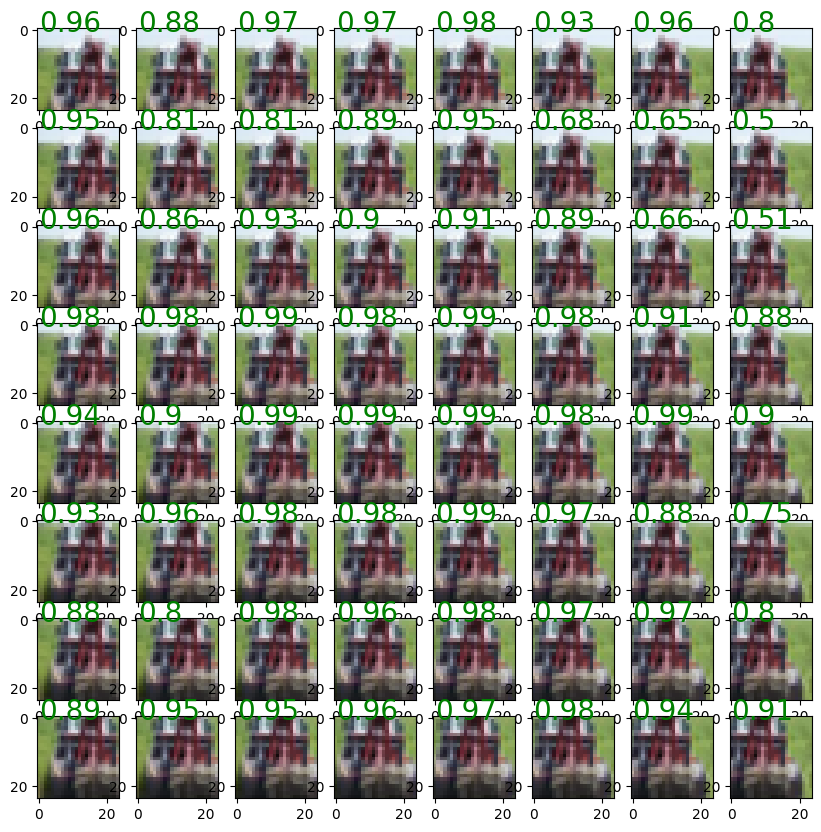

In [12]:
f, axarr = plt.subplots(8,8, figsize=(10,10)) 

for i in range(8): 
    pos = 0 
    for x, score in offset_predictions[i*8:][:8]: 
        axarr[i, pos].imshow(x.cpu().numpy().transpose(1,2,0)) 
        axarr[i, pos].text(0.0, 0.5, str(round(score,2)), dict(size=20, color='green'))
        pos += 1 

### Anti-Aliasing by Blurring

In [13]:
class BlurLayer(nn.Module):
    def __init__(self, kernel_size=5, stride=2, D=2):
        super(BlurLayer, self).__init__()
        
        base_1d = scipy.stats.binom.pmf(list(range(kernel_size)), kernel_size, p=0.5)
        if D <= 0 or D > 3:
            raise Exception() 
        if D >= 1:
            z = base_1d 
        if D >= 2:
            z = base_1d[:,None]*z[None,:] 
        if D >= 3:
            z = base_1d[:,None,None]*z 
        self.weight = nn.Parameter(torch.tensor(z, dtype=torch.float32).unsqueeze(0), requires_grad=False)
        self.stride = stride

    def forward(self, x):
        C = x.size(1) 
        ks = self.weight.size(0)

        if len(self.weight.shape)-1 == 1:
            return F.conv1d(x, torch.stack([self.weight]*C), stride=self.stride, groups=C, padding=ks//self.stride)
        elif len(self.weight.shape)-1 == 2:
            return F.conv2d(x, torch.stack([self.weight]*C), stride=self.stride, groups=C, padding=ks//self.stride)
        elif len(self.weight.shape)-1 == 3:
            return F.conv3d(x, torch.stack([self.weight]*C), stride=self.stride, groups=C, padding=ks//self.stride)
        else:
            raise Exception() 

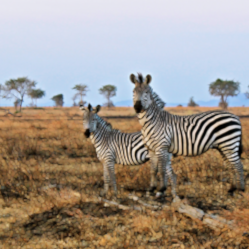

In [14]:
# Apply Max-Pooling with a Stride of 1
tmp = F.max_pool2d(img_tensor_big, (shrink_factor,shrink_factor), stride=1, padding=shrink_factor//2) 

# Blue the Max-Pooling Result
img_tensor_small_better = BlurLayer(kernel_size=int(1.5*shrink_factor), stride=shrink_factor)(tmp.unsqueeze(0)) 
to_img(img_tensor_small_better.squeeze()) #show the result

### Applying Anti-Aliased Pooling

In [15]:
class MaxPool2dAA(nn.Module):
    def __init__(self, kernel_size=2, ratio=1.7):
        super(MaxPool2dAA, self).__init__()

        blur_ks = int(ratio*kernel_size) 
        self.blur = BlurLayer(kernel_size=blur_ks, stride=kernel_size, D=2) 
        self.kernel_size = kernel_size 

    def forward(self, x):
        ks = self.kernel_size 
        tmp = F.max_pool2d(x, ks, stride=1, padding=ks//2) 
        return self.blur(tmp)

In [16]:
aaPool_CNN = nn.Sequential( 
    cnnLayer(C, h, filter_size), 
    cnnLayer(h, h, filter_size),
    MaxPool2dAA(2),
    cnnLayer(h, h, filter_size),
    cnnLayer(h, h, filter_size),
    MaxPool2dAA(2),
    cnnLayer(h, h, filter_size),
    cnnLayer(h, h, filter_size),
    nn.Flatten(),
    nn.Linear((24//(2**pooling_rounds))**2*h, len(cifar10_classes))
)

optimizer = torch.optim.AdamW(aaPool_CNN.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

In [17]:
aaPool_results = train_network(aaPool_CNN, 
loss, 
train_loader, 
epochs=epochs, 
device=device, 
test_loader=test_loader, 
optimizer=optimizer, 
lr_schedule=scheduler, 
score_funcs={'Accuracy': accuracy_score})

Training: 100%|█████████▉| 390/391 [00:11<00:00, 38.75it/s]
                                                           
Training: 100%|██████████| 391/391 [00:10<00:00, 39.98it/s]
                                                           
Training:  99%|█████████▉| 387/391 [00:10<00:00, 37.82it/s]
                                                           
Training: 100%|██████████| 391/391 [00:10<00:00, 41.08it/s]
                                                           
Training:  99%|█████████▉| 387/391 [00:10<00:00, 38.77it/s]
                                                           
Training:  99%|█████████▉| 388/391 [00:10<00:00, 39.28it/s]
                                                           
Training:  99%|█████████▉| 387/391 [00:10<00:00, 38.25it/s]
                                                           
Training:  99%|█████████▉| 388/391 [00:10<00:00, 40.60it/s]
                                                           
Training:  99%|█████████▉| 387/391 [00:1

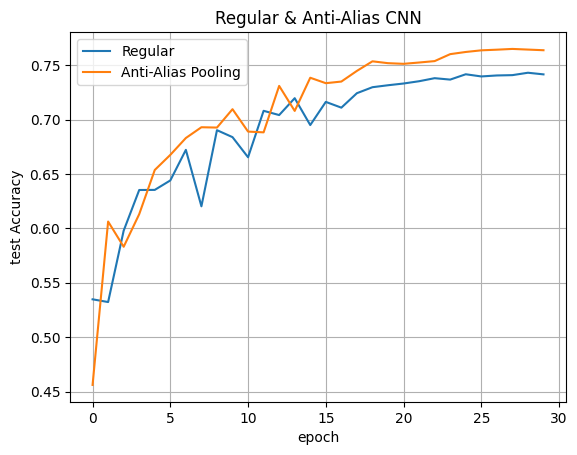

In [18]:
sns.lineplot(x='epoch', 
y='test Accuracy', 
data=normal_results, 
label='Regular')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=aaPool_results, 
label='Anti-Alias Pooling')

plt.title('Regular & Anti-Alias CNN')
plt.grid(True)
plt.show()

[Text(0.5, 0, 'Pixel shifts'),
 Text(0, 0.5, 'Predicted probability of correct class')]

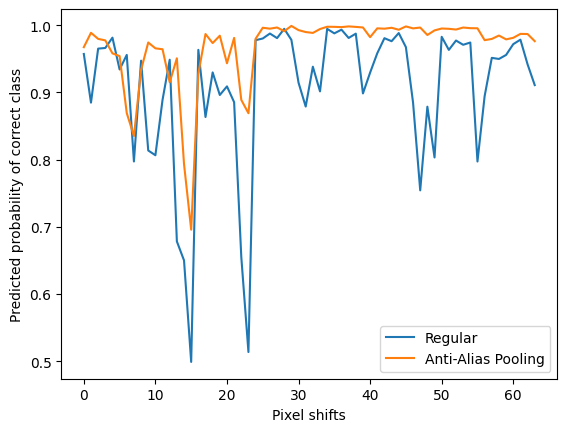

In [19]:
x, y = testset_nocrop[test_img_id] 

offset_predictions_aa = [] 

aaPool_CNN = aaPool_CNN.eval()

for i in range(8): 
    for j in range(8): 
        x_crop = x[:,i:i+24, j:j+24].to(device) 
        with torch.no_grad(): 
            prob_y = F.softmax(aaPool_CNN(x_crop.unsqueeze(0)), dim=-1).cpu().numpy()[0,y] 
            offset_predictions_aa.append((x_crop, prob_y)) 

# Regular Model
sns.lineplot(x=list(range(8*8)), y=[val for img,val in offset_predictions], label='Regular')

# Anti-Alias Pooling
ax = sns.lineplot(x=list(range(8*8)), y=[val for img,val in offset_predictions_aa], label='Anti-Alias Pooling')

# Pixel Shifts
ax.set(xlabel='Pixel shifts', ylabel='Predicted probability of correct class')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6961dd78-5446-4d7d-824a-0529bbdeb3dc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>